In [1]:
#basic libraries
import pandas as pd
import numpy as np
import warnings
!pip install ppscore
warnings.filterwarnings("ignore")
import ppscore as pps
import ast
from tqdm.notebook import tqdm
import math
from collections import Counter

#visualization
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use("ggplot")

#statistical analysis & machine learning
from sklearn.cluster import KMeans as KM
from sklearn.metrics import silhouette_score as score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import train_test_split as splitter
from sklearn.model_selection import cross_val_score as validator
from statsmodels.stats import power as sms
from scipy.stats import pearsonr, shapiro, ttest_ind, f_oneway, levene

#text preprocessing
import nltk
from collections import Counter
import string
from nltk.corpus import stopwords

You should consider upgrading via the 'c:\users\adith\envs\myproject\scripts\python.exe -m pip install --upgrade pip' command.
  Created wheel for ppscore: filename=ppscore-1.1.1-py2.py3-none-any.whl size=12994 sha256=66b18ac59cb70010e4608016a1dc4497f371a20605bd3130073151d5aa872b80
  Stored in directory: c:\users\adith\appdata\local\pip\cache\wheels\d0\1f\c4\e619fb20c9b10df8ddde15d583197edef8c2f27d7b1f29c633
Successfully built ppscore


ModuleNotFoundError: No module named 'tqdm'

In [2]:
#FUNCTIONS NEEDED FOR OUR MODEL DEFINED
#string representation of list -> list
def str2list(x):
    try:
        return ast.literal_eval(x)
    except:
        return np.nan

#accuracy metric
def accuracy(true, pred):
    return sum(true == pred)/len(pred)

#calculate accuracy of knn model (imputing algorithm 1)
def knn_score(k, X_known, y_known):
    model = KNN(n_neighbors = k)
    return validator(model, X_known, y_known, cv=5)

#calculate accuracy of many models
def many_knn_score(start_n, end_n, X_known, y_known):
    scores = []
    for i in range(start_n, end_n):
        scores.append(knn_score(i, X_known, y_known).mean())
    progress = pd.Series(scores, index = np.arange(start_n, end_n))
    fig = plt.figure(figsize = (10, 10))
    ax = fig.subplots()
    progress.plot(ax=ax, kind="line")
    ax.set_ylabel("accuracy")
    ax.set_xlabel("n_neighbors")
    plt.show()

#cosine similarity
def cosine_similarity(x1, x2):
    return np.dot(x1, x2)/(np.linalg.norm(x1)*np.linalg.norm(x2))

#imputing algorithm 2
def similarity_algorithm(X_train):
    similarity_lists = []
    for x in tqdm(range(len(X_train))):
        similarity_list = []
        for genre in range(len(genre_profile)):
            similarity = cosine_similarity(X_train.iloc[x], genre_profile.iloc[genre])
            similarity_list.append(similarity)
        similarity_lists.append(similarity_list)
    df = pd.DataFrame(similarity_lists, columns=popular_genres) 
    return df.transpose()

#silhouette score
def calc_silhouette(X, y):
    return score(X, y)

#determine clusters and find out how good model is using silhouette score, t-test and/or anova
def k_means(data, n_clusters, n_components=2):
    model = KM(n_clusters=n_clusters)
    model.fit(df_std)
    preds = model.predict(data)
    decomposer = PCA(n_components=n_components)
    decomposer.fit(df_std)
    data_for_plot = decomposer.transform(data)
    cols = ["x"+str(x+1) for x in range(n_components)]
    df_genre_profile = pd.DataFrame(data_for_plot, index=data.index, columns=cols)
    df_genre_profile["cluster"] = preds
    cluster_score = calc_silhouette(data, preds)
    tester = Test(alpha=0.05)
    anova_score = tester.anova(*[df_genre_profile[df_genre_profile["cluster"] == x]["x1"].values for x in range(n_clusters)])
    anova_score = anova_score["anova_stat"] if anova_score["test_is_accepted"] else None
    ttest_score = None
    if n_clusters == 2:
        ttest_score = tester.ttest(df_genre_profile[df_genre_profile["cluster"] == 0]["x1"].values,
                                   df_genre_profile[df_genre_profile["cluster"] == 1]["x1"].values)
        ttest_score = ttest_score["ttest_stat"] if ttest_score["test_is_accepted"] else None
    return df_genre_profile, cluster_score, anova_score, ttest_score

#plot a kmeans model
def plot_k_means(data, n_clusters):
    df_genre_profile, cluster_score, anova_score, ttest_score = k_means(data=data, n_clusters=n_clusters)
    rgb_colormap = np.random.randint(0, 255, size=(n_clusters, 3))/255
    rgb_values = rgb_colormap[df_genre_profile["cluster"]]
    
    fig = plt.figure(figsize = (10, 10))
    ax = fig.subplots()
    df_genre_profile.plot(ax=ax, x="x1", y="x2", kind = "scatter", c = rgb_values)
    string = f"n_clusters: {n_clusters}, silhouette: {cluster_score:.4f}"
    if anova_score:
        string += f", t-test: {list(test_score)[0]:.4f}"
    if ttest_score:
        string += f", anova: {list(anova_score)[0]:.4f}"
    ax.set_title(string)
    return ax

#plot many k-means models based on different n_clusters
def k_many_clusters(data, start_n, end_n):
    for i in range(start_n, end_n):
        plot_k_means(data, i)
        plt.show()
        
#Test class includes both ttest and anova tests
class Test():
    def __init__(self, alpha, power=0.90, only_result=True, ind_limit=0.20):
        """alpha and power required for identifying the min. sample size
        and ind_limit that defines the dependence using correlation coefficient"""
        self.alpha = alpha
        self.power = power
        self.only_result = only_result
        self.ind_limit = ind_limit
    def ttest(self, a, b):
        """min. sample size, shapiro, pearsonr and ttest, and their corresponding p-values"""
        only_result = self.only_result
        power, alpha = self.power, self.alpha
        p_a = a.mean()
        p_b = b.mean()
        n_a = len(a)
        n_b = len(b)
        effect_size = (p_b-p_a)/a.std()
        n_req = int(sms.TTestPower().solve_power(effect_size=effect_size, power=power, alpha=alpha))
        if len(a) > len(b):
            a = a[:len(b)]
        elif len(a) < len(b):
            b = b[:len(a)]
        stat1, p1 = shapiro(a)
        stat2, p2 = shapiro(b)
        stat3, p3 = pearsonr(a, b)
        stat4, p4 = ttest_ind(b, a)
        
        result_dict = {"power": power, "alpha": alpha, "n_req": n_req,
                       "n_control": n_a, "n_test": n_b, "shapiro_control_stat": stat1,
                       "shapiro_control_p": p1, "shapiro_test_stat": stat2, "shapiro_test_p": p2,
                       "pearsonr_stat": stat3, "pearsonr_p": p3, "ttest_stat": stat4,
                       "ttest_p": p4, "ind_limit": self.ind_limit, "very_low_number": n_req > n_a or n_req > n_b,
                       "control_is_normal": alpha < p1, "test_is_normal": alpha < p2,
                       "very_low_correlation": self.ind_limit > abs(stat3), "very_high_dependence": p3 < alpha,
                       "no_difference": p4 > alpha, "test_is_bigger": stat4 > 0, "control_is_bigger": stat4 < 0}
        
        accepted = all([
            not(result_dict["very_low_number"]),
            (result_dict["control_is_normal"] and result_dict["test_is_normal"]),
            (not(result_dict["very_high_dependence"]) or result_dict["very_low_correlation"])
        ])
        
        result_dict.update({"test_is_accepted": accepted})
        result_dict = {key: result_dict[key] for key in ["ttest_stat", "ttest_p", "test_is_accepted"]} if only_result else result_dict
        return result_dict
    def anova(self, *args):
        """shapiro, levene, one-way anova and their corresponding p-values"""
        only_result = self.only_result
        alpha = self.alpha
        normality = [shapiro(x) for x in args]
        every_group_is_normal = True if all([x[1] > alpha for x in normality]) else False
        stat1, p1 = levene(*args)
        equal_variance = False if(p1 < alpha) else True
        stat2, p2 = f_oneway(*args)
        equal_means = False if (p2 < alpha) else True
        accepted = all([every_group_is_normal, equal_variance, not(equal_means)])
        result_dict = {"alpha": alpha, "normality":every_group_is_normal, "levene_stat":stat1, "levene_p": p1,
                       "homogenity": equal_variance, "anova_stat": stat2, "anova_p": p2, 
                       "groups_are_different": not(equal_means), "test_is_accepted": accepted}
        result_dict = {key: result_dict[key] for key in ["anova_stat", "anova_p", "test_is_accepted"]} if only_result else result_dict
        return result_dict
    
#predictions over new data
def predict_cluster(sample):
    sample = sample.copy()
    for i in range(len(in_cols)):
        col = in_cols[i]
        sample[col] = (sample[col]-genre_means[i])/genre_stds[i]
    df_genre_profile = k_means(sample, 4)[0]
    return df_genre_profile["cluster"].to_dict()

#generate fake name for clusters
def create_cluster_name(artists_clusters):
    counts = []
    artists_data = [artists_clusters.query("cluster == "+str(x)).index for x in range(4)]
    for data in artists_data:
        data_string = " ".join(data).lower()
        tokens = nltk.word_tokenize(data_string)
        stopset = set(stopwords.words('english') + list(string.punctuation) + ["orchestra", "band", "symphony"])
        data = [token for token in tokens if token not in stopset and len(token) > 2]
        count = pd.Series(dict(Counter(data)))
        counts.append(count.sort_values(ascending=False)[:3].to_dict())
    name_dict = {}
    for i, count in enumerate(counts):
        indices = np.random.permutation(len(count))
        count = np.array(list(count.keys()))
        count = count[indices]
        genre_name = " ".join(count)
        name_dict.update({"Cluster "+str(i): genre_name})
    return name_dict

In [3]:
df = pd.read_csv("./data/data_by_genres.csv")
df_2 = pd.read_csv("./data/data_w_genres.csv")

In [4]:
out_cols = ["genres", "artists", "mode", "count", "key"] #WE WONT USE THESE ATTRIBUTES FOR CLASSIFICATION
in_cols = [x for x in df.columns if x not in out_cols] #IMPORTANT ATTRIPUTES WHICH WE WILL BE OUR PARAMETERS FOR CLASSIFICATION

df = df.set_index("genres")[in_cols].drop("[]", 0)
df #genre data

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity
genres,,,,,,,,,,,
432hz,0.494780,0.299333,1.048887e+06,0.450678,0.477762,0.131000,-16.854000,0.076817,120.285667,0.221750,52.166667
a cappella,0.621532,0.577017,1.936522e+05,0.345694,0.003799,0.127087,-12.770211,0.095324,111.813230,0.453186,43.351819
abstract,0.359395,0.459500,3.430185e+05,0.487000,0.791400,0.119480,-14.092000,0.043420,124.743200,0.304990,41.500000
abstract beats,0.353347,0.694400,2.338244e+05,0.613400,0.349403,0.102453,-6.699800,0.143453,119.398400,0.634187,58.600000
abstract hip hop,0.205872,0.723132,2.490951e+05,0.645461,0.002853,0.168032,-7.216007,0.250104,112.160287,0.584392,43.804971
...,...,...,...,...,...,...,...,...,...,...,...
zolo,0.218600,0.560365,2.675453e+05,0.611985,0.152665,0.190792,-11.499268,0.064295,123.283566,0.596705,33.760410
zouglou,0.124000,0.834000,2.951470e+05,0.674000,0.000000,0.082800,-13.455000,0.072100,119.039000,0.951000,56.000000
zouk,0.233181,0.752762,2.951100e+05,0.627238,0.301195,0.083224,-10.864476,0.038110,101.681762,0.844381,42.476190


In [5]:
#fill nan values by 0
df_2.set_index("artists", inplace=True)
df_2["genres"][df_2["genres"] == "[]"] = np.nan
df_2["genres"] = df_2["genres"].fillna(0)
df_2

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres
artists,,,,,,,,,,,,,,,
"""Cats"" 1981 Original London Cast",0.575083,0.442750,247260.000000,0.386336,0.022717,0.287708,-14.205417,0.180675,115.983500,0.334433,38.000000,5,1,12,['show tunes']
"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,33.076923,5,1,26,0
"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.285714,0,1,7,0
"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.444444,0,1,27,0
"""Joseph And The Amazing Technicolor Dreamcoat"" 1991 London Cast",0.605444,0.437333,232428.111111,0.429333,0.037534,0.216111,-11.447222,0.086000,120.329667,0.458667,42.555556,11,1,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
鳳飛飛,0.884000,0.358000,259387.000000,0.208000,0.000002,0.150000,-9.524000,0.033900,131.261000,0.278000,35.000000,10,1,2,"['c-pop', 'classic mandopop', 'vintage chinese..."
黃品源,0.541000,0.578000,293840.000000,0.334000,0.000006,0.067500,-11.974000,0.026700,135.934000,0.243000,47.000000,9,0,2,"['c-pop', 'classic cantopop', 'classic mandopop']"
黃國隆,0.785455,0.570818,174582.727273,0.148400,0.000083,0.142191,-21.610091,0.054355,119.586273,0.741273,20.000000,5,1,11,0


In [6]:
#standardize data
df_2_std = df_2.copy()
for col in in_cols:
    df_2_std[col] = (df_2[col]-df_2[col].mean())/df_2[col].std()
       
#extract individual genres from genre lists
df_2_std.reset_index(inplace = True)
collist = list(df_2_std.columns)
new_rows = []
for index in tqdm(range(len(df_2_std))):
    row = df_2_std.iloc[index]
    genre_list = str2list(row["genres"])
    row = pd.DataFrame(row).transpose()
    if(not(isinstance(genre_list, list) and len(genre_list) != 0)):
        pass
    else:
        if(len(genre_list) == 1):
            row["genres"] = genre_list[0]
            new_rows.append(list(row.values[0]))
        else:
            row = pd.concat([row for i in range(len(genre_list))], 0)
            row["genres"] = genre_list
            for i in range(len(genre_list)):
                new_rows.append(list(row.values[i]))
                
df_known = pd.DataFrame(new_rows, columns = collist)

In [7]:
#export
df_known.to_csv("data_each_genres.csv")
df_known

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres
0,"""Cats"" 1981 Original London Cast",0.190466,-0.577296,0.080771,-0.423451,-0.492733,0.599422,-0.512587,0.728019,0.021651,-0.746385,0.167910,5,1,12,show tunes
1,"""Weird Al"" Yankovic",-0.886229,0.683578,-0.159728,0.754944,-0.570338,-0.295508,0.231051,-0.118793,0.678476,0.979750,-0.027445,9,1,132,antiviral pop
2,"""Weird Al"" Yankovic",-0.886229,0.683578,-0.159728,0.754944,-0.570338,-0.295508,0.231051,-0.118793,0.678476,0.979750,-0.027445,9,1,132,comedy rock
3,"""Weird Al"" Yankovic",-0.886229,0.683578,-0.159728,0.754944,-0.570338,-0.295508,0.231051,-0.118793,0.678476,0.979750,-0.027445,9,1,132,comic
4,"""Weird Al"" Yankovic",-0.886229,0.683578,-0.159728,0.754944,-0.570338,-0.295508,0.231051,-0.118793,0.678476,0.979750,-0.027445,9,1,132,parody
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64087,黃品源,0.098297,0.190741,0.465804,-0.629850,-0.570476,-0.970003,-0.129141,-0.598644,0.815275,-1.122184,0.575073,9,0,2,c-pop
64088,黃品源,0.098297,0.190741,0.465804,-0.629850,-0.570476,-0.970003,-0.129141,-0.598644,0.815275,-1.122184,0.575073,9,0,2,classic cantopop
64089,黃品源,0.098297,0.190741,0.465804,-0.629850,-0.570476,-0.970003,-0.129141,-0.598644,0.815275,-1.122184,0.575073,9,0,2,classic mandopop
64090,黑豹,-0.334384,-1.086954,0.650302,0.758350,-0.570497,-1.046262,0.364211,-0.488358,3.377364,-0.674185,-0.013051,11,1,2,chinese indie


In [8]:
X_known = df_known[in_cols]
y_known = df_known["genres"]

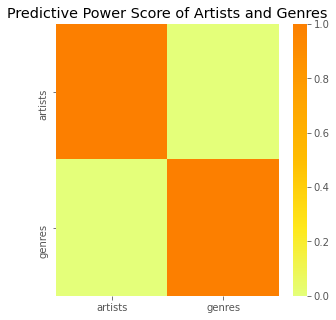

In [9]:
correlations = pps.matrix(df_known.reset_index()[["artists", "genres"]])

fig = plt.figure(figsize=(5, 5))
ax = fig.subplots()
sns.heatmap(pd.DataFrame(correlations["ppscore"].values.reshape(2, 2),
                         columns = ["artists", "genres"], index = ["artists", "genres"]),
                         cmap = "Wistia", axes = ax)
ax.set_title("Predictive Power Score of Artists and Genres")
plt.show()

as we can see, artist predictive power is very low so it is not a good attribut for genre classification

In [10]:
y_known.value_counts()[:30].to_dict()

{'pop': 638,
 'rock': 612,
 'dance pop': 570,
 'rap': 521,
 'hip hop': 514,
 'pop rap': 488,
 'pop rock': 462,
 'indie pop': 401,
 'country rock': 398,
 'folk rock': 394,
 'urban contemporary': 390,
 'latin': 389,
 'modern rock': 388,
 'southern hip hop': 377,
 'soft rock': 363,
 'trap': 361,
 'mellow gold': 358,
 'funk': 344,
 'roots rock': 336,
 'classic rock': 331,
 'album rock': 329,
 'adult standards': 327,
 'alternative rock': 324,
 'indie rock': 323,
 'gangster rap': 311,
 'country': 309,
 'alternative metal': 299,
 'new wave pop': 295,
 'r&b': 295,
 'quiet storm': 294}

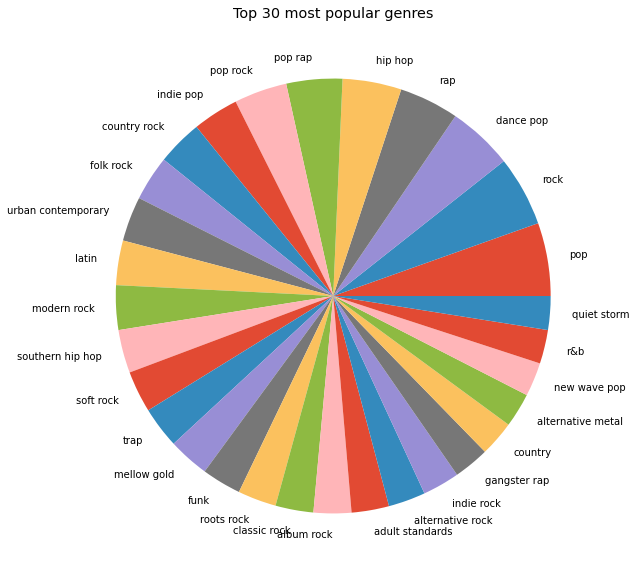

In [11]:
fig = plt.figure(figsize = (10, 10))
ax = fig.subplots()
y_known.value_counts()[:30].plot(ax=ax, kind = "pie")
ax.set_ylabel("")
ax.set_title("Top 30 most popular genres")
plt.show()

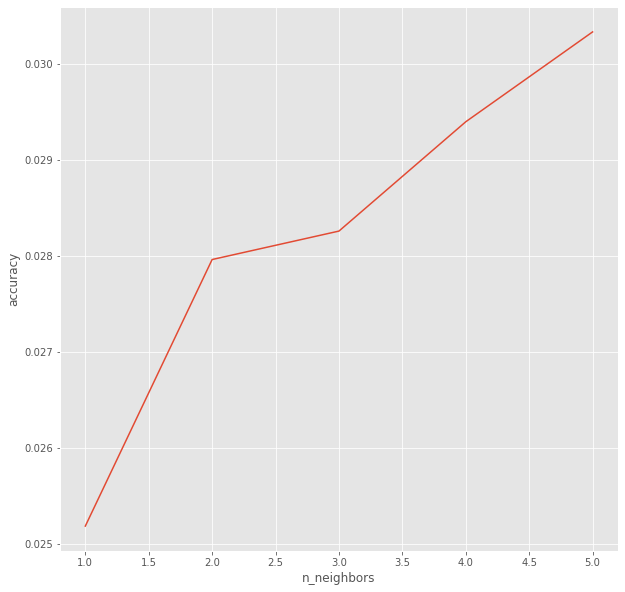

In [12]:
many_knn_score(1, 6, X_known, y_known) #plotting accuracy of our model for different values of k

AS WE CAN SEE,THIS GIVES A VERY LOW ACCURACY(APPROX 0.030) SO I TRIED TO IMPROVE IT

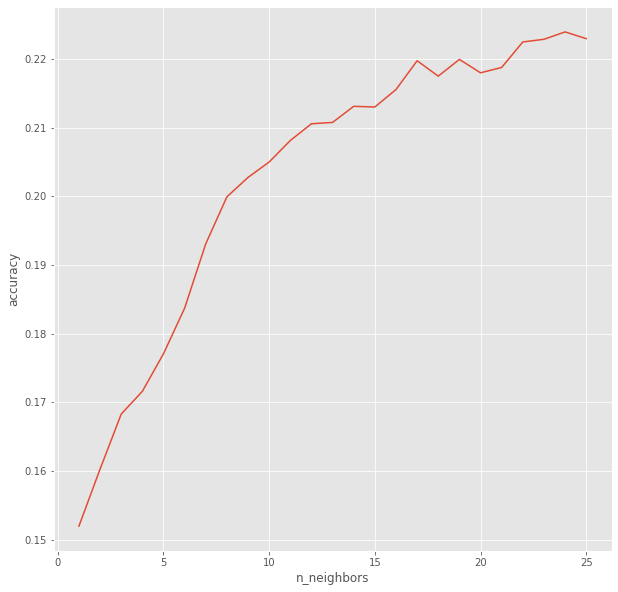

In [13]:
popular_genres = list(y_known.value_counts()[:25].index)
df_known_w_populars = df_known[df_known["genres"].isin(popular_genres)]
X_known_w_populars = df_known_w_populars[in_cols]
y_known_w_populars = df_known_w_populars["genres"]

many_knn_score(1, 26, X_known_w_populars, y_known_w_populars) #plotting accuracy of our model using different values of k
                                                                #using only popular genres

now the accuracy has increased to 0.22!that means that trying to train & test our model only on the 30 most popular genres gave a much better result & increased our accuracy by a lot!

In [14]:
genre_profile = df_known_w_populars[["genres", *in_cols]].groupby("genres").mean()
similarity_matrix=similarity_algorithm(X_known)

preds=list(similarity_matrix.index[similarity_matrix.values.argmax(axis=0)])

accuracy(preds, y_known) #trying cosine similarity measure & testing its accuracy

0.004337514822442739

i also tried using cosine similarity for knn, but that actually has the least accuracy of all & also consumes way too many resources & takes a lot of time so , it is rejected.
I decided not to use knn for inputting missing genres as the accuracy is very low(0.22) hence i cant just use knn to simply input the missing genre

In [15]:
genre_means, genre_stds = [], []
df_std = df.copy()
for col in in_cols:
    mean = df_std[col].mean()
    std = df_std[col].std()
    genre_means.append(mean)
    genre_stds.append(std)
    df_std[col] = (df_std[col] - mean) / std
df_std #standardizing more

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity
genres,,,,,,,,,,,
432hz,0.305215,-1.596574,8.825970,-0.501401,1.083396,-0.714143,-1.296810,-0.086290,0.081855,-1.404273,0.751718
a cappella,0.708935,0.272280,-0.615321,-0.962798,-0.765438,-0.758603,-0.479318,0.144528,-0.401501,-0.233259,0.201393
abstract,-0.126003,-0.518627,1.033595,-0.341770,2.306837,-0.845030,-0.743914,-0.502799,0.336159,-0.983097,0.085781
abstract beats,-0.145267,1.062287,-0.171843,0.213747,0.582693,-1.038482,0.735855,0.744773,0.031236,0.682567,1.153361
abstract hip hop,-0.614993,1.255655,-0.003264,0.354652,-0.769129,-0.293399,0.632521,2.074877,-0.381701,0.430615,0.229684
...,...,...,...,...,...,...,...,...,...,...,...
zolo,-0.574452,0.160211,0.200415,0.207529,-0.184741,-0.034802,-0.224901,-0.242461,0.252887,0.492915,-0.397414
zouglou,-0.875765,2.001816,0.505122,0.480079,-0.780257,-1.261777,-0.616399,-0.145114,0.010732,2.285573,0.991039
zouk,-0.528010,1.455071,0.504713,0.274564,0.394643,-1.256962,-0.097829,-0.569029,-0.979505,1.746104,0.146726


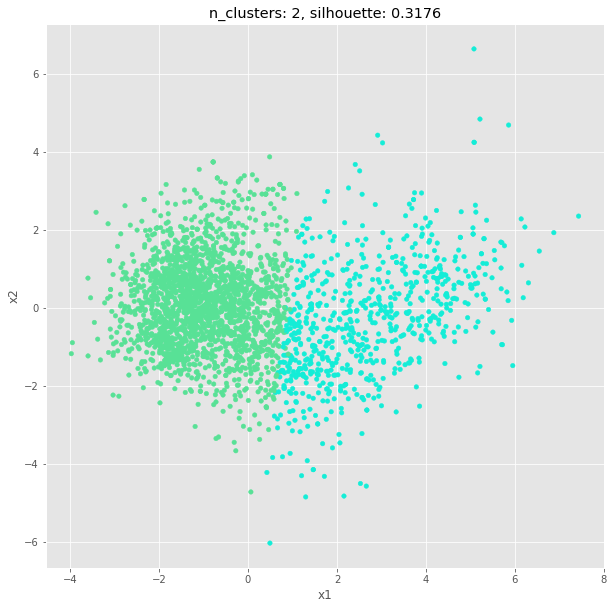

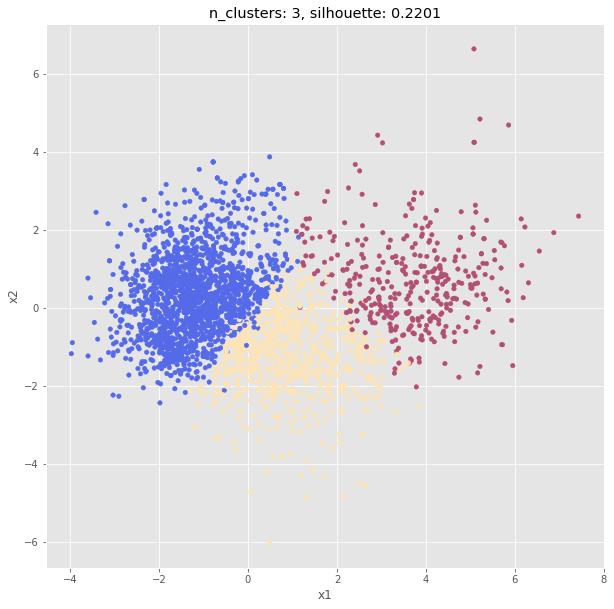

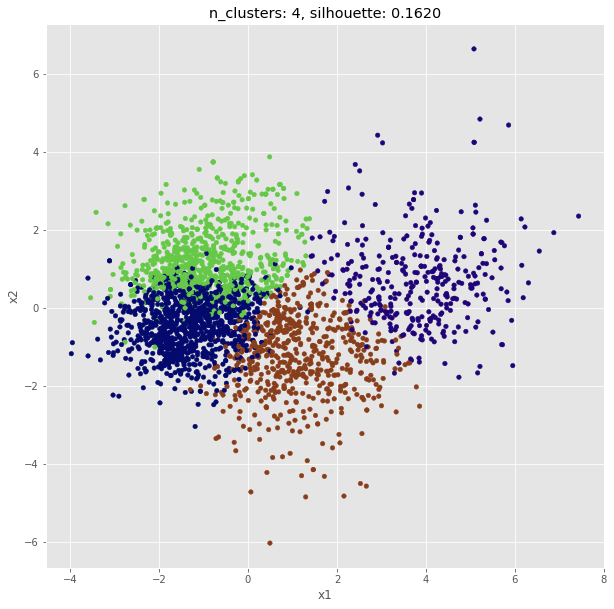

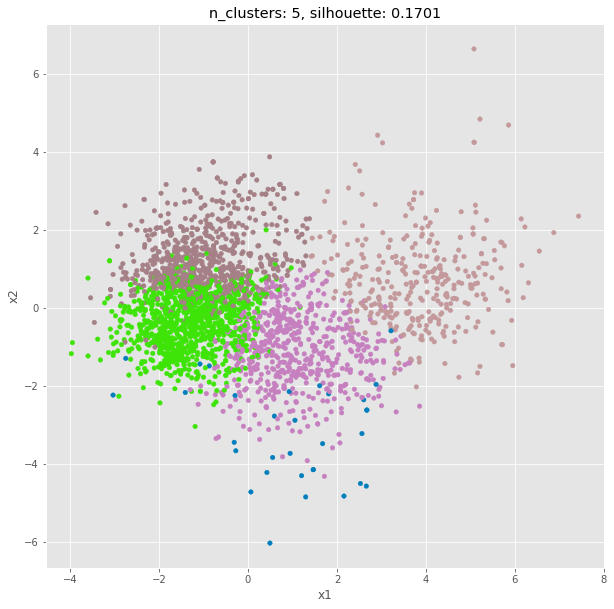

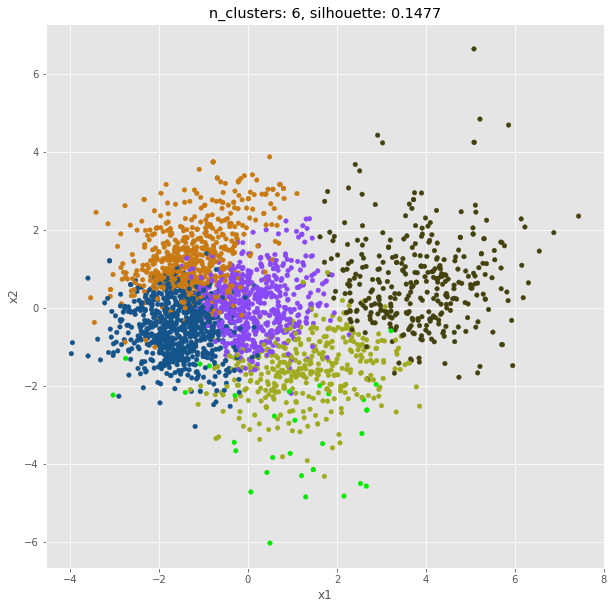

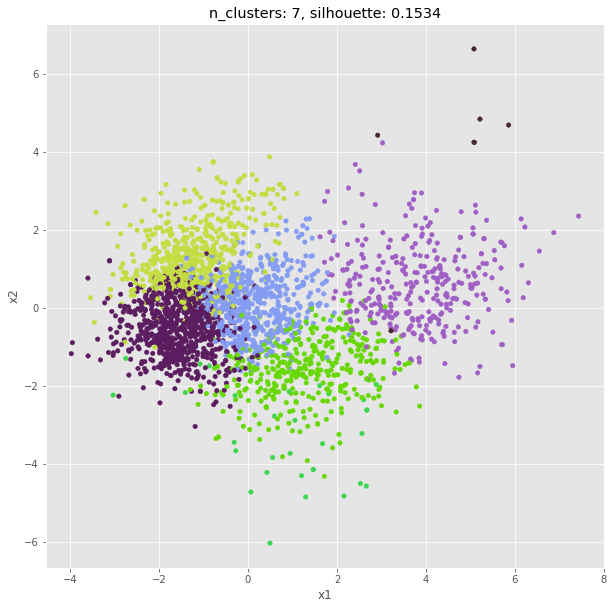

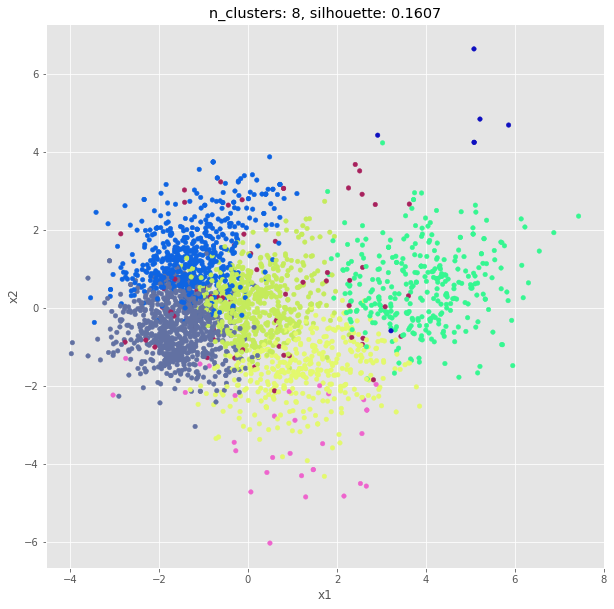

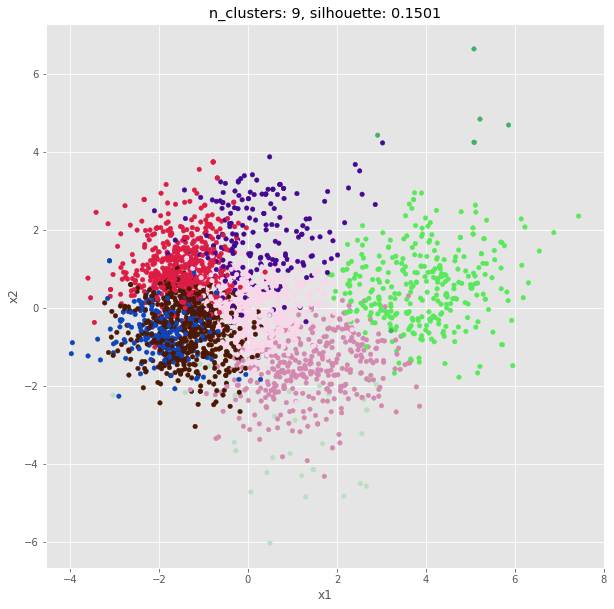

In [16]:
k_many_clusters(df_std, 2, 10) #plotting clusters for different values of k & printing silhouette scores of all clusters

I used PCA to decompose the components & used k means clustering for plotting clusters for k=2-10
I saw as clusters increased,the silhouette score kept decreasing which means that the goodness of the model was decreasing.

In [17]:
i = 2
tester = Test(alpha = 0.05, only_result=False)
df_genre_profile = k_means(df_std, 2)[0]
ttest_result = tester.ttest(df_genre_profile[df_genre_profile["cluster"] == 0]["x1"].values, df_genre_profile[df_genre_profile["cluster"] == 1]["x1"].values)

ttest_result

{'power': 0.9,
 'alpha': 0.05,
 'n_req': 2,
 'n_control': 1949,
 'n_test': 714,
 'shapiro_control_stat': 0.9844116568565369,
 'shapiro_control_p': 6.728691346324922e-07,
 'shapiro_test_stat': 0.9514012336730957,
 'shapiro_test_p': 1.3774021189578121e-14,
 'pearsonr_stat': 0.0013209574448132203,
 'pearsonr_p': 0.9718922082613458,
 'ttest_stat': 58.28722474551537,
 'ttest_p': 0.0,
 'ind_limit': 0.2,
 'very_low_number': False,
 'control_is_normal': False,
 'test_is_normal': False,
 'very_low_correlation': True,
 'very_high_dependence': False,
 'no_difference': False,
 'test_is_bigger': True,
 'control_is_bigger': False,
 'test_is_accepted': False}

One-Way ANOVA and T-Test are rejected because our data wasnt normally distributed.(after PCA)
This data is not normally distributed, because in fact at the beginning we are transforming a multi-dimensional normal data into a single-dimensional non-normal data via PCA , so our tests are rejected everytime & our data isn't normal

In [18]:
anova_results = []
for i in range(2, 9):
    tester = Test(alpha=0.05, only_result=False)
    df_genre_profile = k_means(df_std, i)[0]
    test_data = [df_genre_profile[df_genre_profile["cluster"] == x]["x1"] for x in range(i)]
    anova_results.append(tester.anova(*test_data))
    
pd.DataFrame(anova_results)

,alpha,normality,levene_stat,levene_p,homogenity,anova_stat,anova_p,groups_are_different,test_is_accepted
0,0.05,False,234.721543,7.725671e-51,False,6129.835016,0.0,True,False
1,0.05,False,35.877221,4.218634e-16,False,4679.055745,0.0,True,False
2,0.05,False,20.453918,4.215501e-13,False,3208.039950,0.0,True,False
3,0.05,False,22.264735,4.191028e-18,False,2370.652687,0.0,True,False
4,0.05,False,53.118266,1.086053e-52,False,2482.047389,0.0,True,False
5,0.05,False,38.785888,2.113595e-45,False,2075.198771,0.0,True,False
6,0.05,False,40.134621,5.730236e-54,False,1980.636161,0.0,True,False


 Normality and homogenity are not fulfilled, so the test was rejected every time. However , As the number of clusters increases, the mean difference becomes lesser, so picking a low number is a better . The distribution is the most homogenous if the number of clusters is equal to 4 or 5 (levene-p is high and variance score is low). We pick 4 as the number of clusters because its silhouette score is higher

In [19]:
#predictions over new samples
#e.g. predict_cluster(df.iloc[:350])

#prediction over all data
{k: v for i, (k, v) in enumerate(predict_cluster(df).items()) if i%100==0}

{'432hz': 0,
 'argentine indie': 1,
 'baroque singing': 0,
 'brazilian punk': 3,
 'cancion melodica': 1,
 'christian power metal': 2,
 'comedy rap': 3,
 'dark cabaret': 2,
 'dixieland': 1,
 'enka': 1,
 'french metal': 2,
 'greek clarinet': 1,
 'icelandic experimental': 0,
 'italian gothic': 2,
 'jazz tuba': 1,
 'lilith': 3,
 'miami indie': 3,
 'naija worship': 2,
 'norwegian hip hop': 3,
 'panpipe': 0,
 'power-pop punk': 2,
 'riddim': 3,
 'sevdah': 3,
 'spanish renaissance': 0,
 'taiwan singer-songwriter': 1,
 'uk americana': 1,
 'vocal jazz': 1}

In [20]:
pred = predict_cluster(df)

df_known_new = df_known.copy()
df_known_new["cluster"] = df_known_new["genres"].map(lambda x: pred[x])
df_known_new #clustering all our music & assigning all songs to some cluster.

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres,cluster
0,"""Cats"" 1981 Original London Cast",0.190466,-0.577296,0.080771,-0.423451,-0.492733,0.599422,-0.512587,0.728019,0.021651,-0.746385,0.167910,5,1,12,show tunes,0
1,"""Weird Al"" Yankovic",-0.886229,0.683578,-0.159728,0.754944,-0.570338,-0.295508,0.231051,-0.118793,0.678476,0.979750,-0.027445,9,1,132,antiviral pop,0
2,"""Weird Al"" Yankovic",-0.886229,0.683578,-0.159728,0.754944,-0.570338,-0.295508,0.231051,-0.118793,0.678476,0.979750,-0.027445,9,1,132,comedy rock,0
3,"""Weird Al"" Yankovic",-0.886229,0.683578,-0.159728,0.754944,-0.570338,-0.295508,0.231051,-0.118793,0.678476,0.979750,-0.027445,9,1,132,comic,0
4,"""Weird Al"" Yankovic",-0.886229,0.683578,-0.159728,0.754944,-0.570338,-0.295508,0.231051,-0.118793,0.678476,0.979750,-0.027445,9,1,132,parody,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64087,黃品源,0.098297,0.190741,0.465804,-0.629850,-0.570476,-0.970003,-0.129141,-0.598644,0.815275,-1.122184,0.575073,9,0,2,c-pop,3
64088,黃品源,0.098297,0.190741,0.465804,-0.629850,-0.570476,-0.970003,-0.129141,-0.598644,0.815275,-1.122184,0.575073,9,0,2,classic cantopop,3
64089,黃品源,0.098297,0.190741,0.465804,-0.629850,-0.570476,-0.970003,-0.129141,-0.598644,0.815275,-1.122184,0.575073,9,0,2,classic mandopop,3
64090,黑豹,-0.334384,-1.086954,0.650302,0.758350,-0.570497,-1.046262,0.364211,-0.488358,3.377364,-0.674185,-0.013051,11,1,2,chinese indie,0


In [21]:
#artists - clusters (group by artists and find the most frequent clusters)
artists_clusters = df_known_new[["cluster", "artists"]].groupby("artists").agg(lambda x: x.value_counts().index[0])
artists_clusters["cluster"].value_counts(normalize=True)

0    0.480681
3    0.227240
2    0.177436
1    0.114643
Name: cluster, dtype: float64

so i can see that after clustering,most of the songs belong to cluster 0 (about 48%),22% to cluster 3, 17% to cluster 2, 11% to cluster 1

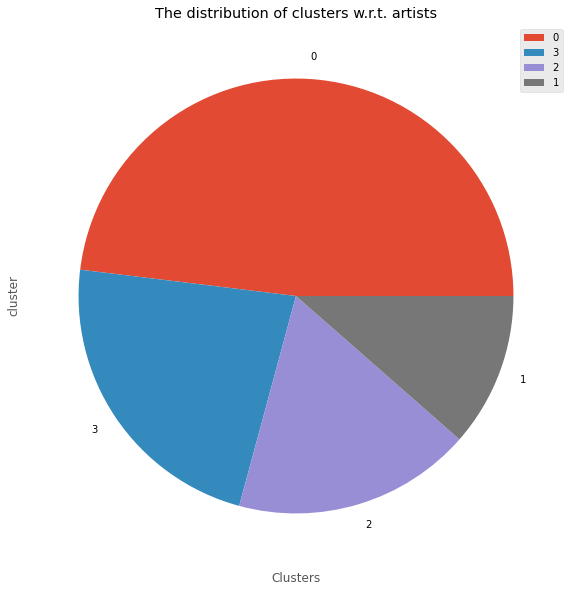

In [22]:
fig = plt.figure(figsize = (10, 10))
ax = fig.subplots()
ax.set_title("The distribution of clusters w.r.t. artists")
ax.set_xlabel("Clusters")
artists_clusters["cluster"].value_counts().plot(ax=ax, kind="pie",  legend=True)
plt.show()

In [23]:
cluster_info=df_known_new.groupby(by="cluster").mean()[in_cols]
cluster_info

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity
cluster,,,,,,,,,,,
0,-0.657102,0.546834,0.029875,0.532317,-0.364660,-0.133106,0.524387,0.025363,0.155570,0.260675,0.642450
1,0.845216,-1.202910,0.530981,-1.076068,1.330610,-0.178790,-1.444193,-0.359527,-0.504846,-1.144195,-0.154717
2,-0.930571,-0.350264,0.094755,0.913908,-0.074774,0.063639,0.588621,-0.230848,0.426646,-0.219934,0.437562
3,0.406513,-0.042463,-0.062351,-0.326666,0.013670,-0.042818,-0.199757,-0.209437,-0.010786,0.195354,-0.291615


So, this is the data of our clusters, as we can see cluster 0 has the highest average popularity, higher speechiness, dancebility average
While, cluster 1 has the highest acousticness average,highest song duraction average,cluster 1 has higher instrumentalness,higher loudness
cluster 2 has higher energy,higher liveliness, & higher tempo


